# Machine Learning Modeling

## 1. Initial setup and data loading

Import necessary libraries and load the preprocessed dataset for modeling. This includes separating the feature variables and the target variable, 'retained'.

In [48]:
import pandas as pd

df = pd.read_csv('../data/data-preprocessed-modeling.csv')
labels = df['retained'].astype(int)
df = df.drop(columns='retained')

df.head()

,age_at_first_participation,age_at_last_participation,unique_chapters_count,multiple_chapters,unique_programs_count,multiple_programs,sessions_rate,avg_price,parent_participant_rate,parent_chapter_rate,...,ethnicity_Middle Eastern,ethnicity_Multi-Racial,ethnicity_Native American or Native Alaskan,ethnicity_Other,ethnicity_Pacific Islander,ethnicity_Prefer not to answer,ethnicity_Prefer not to respond,ethnicity_South Asian,ethnicity_Southeast Asian,ethnicity_White or Caucasian
0,0.000875,0.150496,1.268264,-0.03335,-0.736484,-0.879167,0.191017,-1.735476,-1.034089,-0.797145,...,False,False,False,False,False,False,False,False,False,True
1,-1.602328,-1.672530,1.268264,-0.03335,-0.736484,-0.879167,-0.286985,-1.782983,-1.034089,-0.797145,...,False,False,False,False,False,False,False,False,False,True
2,0.000875,0.931793,1.268264,-0.03335,-0.736484,-0.879167,0.718313,-1.352085,-1.034089,-0.797145,...,False,False,False,False,False,False,False,False,False,True
3,1.069678,1.973522,1.268264,-0.03335,-0.736484,-0.879167,0.718313,-1.735476,-1.034089,-0.797145,...,False,False,False,False,False,False,False,False,False,True
4,-1.335128,-0.370368,1.268264,-0.03335,-0.736484,-0.879167,1.193371,-0.813483,1.016694,-0.797145,...,False,True,False,False,False,False,False,False,False,False


## 2. Data splitting

Split the dataset into training and testing sets. This is essential for evaluating the performance of our models on unseen data.

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42, stratify=labels)

## 3. Handling class imbalance

Use SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance in the training data, ensuring that our models learn to predict both classes effectively.

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## 4. SGD Classifier

Train a Stochastic Gradient Descent (SGD) classifier. This model is known for its efficiency in large-scale and sparse data.

In [53]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

# Build model, fit to data
sgd_clf = SGDClassifier(random_state=42, alpha=0.0001, eta0=1, learning_rate='adaptive', penalty='elasticnet')
sgd_clf.fit(X_train_resampled, y_train_resampled)

# Predict
prediction_sgd = sgd_clf.predict(X_test)
prediction_sgd_df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction_sgd})
prediction_sgd_df.to_csv('../results/sgd-predictions.csv', index=False)

# Calculate cross validation scores
sgd_scores = cross_val_score(sgd_clf, X_train_resampled, y_train_resampled)

with open('../results/sgd-cross-validation.txt', 'w') as f:
    for score in sgd_scores:
        f.write(f'{score}\n')

## 5. Random Forest Classifier

Train a Random Forest classifier. This ensemble learning method is effective for classification and provides insights through feature importances.

In [54]:
from sklearn.ensemble import RandomForestClassifier

# Build model, fit to data
forest_clf = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=2, n_estimators=100, random_state=42)
forest_clf.fit(X_train_resampled, y_train_resampled)

# Predict
prediction_forest = forest_clf.predict(X_test)
prediction_forest_df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction_forest})
prediction_forest_df.to_csv('../results/forest-predictions.csv', index=False)

# Calculate cross validation scores
forest_scores = cross_val_score(RandomForestClassifier(), X_train_resampled, y_train_resampled)

with open('../results/forest-cross-validation.txt', 'w') as f:
    for score in forest_scores:
        f.write(f'{score}\n')

## 6. Model Evaluation

Evaluate the performance of both classifiers using metrics like accuracy, precision, recall, F1 score, and ROC AUC. These metrics provide a comprehensive view of the models' performance.

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate SGD metrics
accuracy_sgd = accuracy_score(y_test, prediction_sgd)
precision_sgd = precision_score(y_test, prediction_sgd)
recall_sgd = recall_score(y_test, prediction_sgd)
f1_sgd = f1_score(y_test, prediction_sgd)
roc_auc_sgd = roc_auc_score(y_test, sgd_clf.decision_function(X_test), average='macro')

# Calculate Random Forest metrics
accuracy_forest = accuracy_score(y_test, prediction_forest)
precision_forest = precision_score(y_test, prediction_forest)
recall_forest = recall_score(y_test, prediction_forest)
f1_forest = f1_score(y_test, prediction_forest)

# Calculate Random Forest probabilities for ROC AUC score
probabilities = forest_clf.predict_proba(X_test)[:, 1]
roc_auc_forest = roc_auc_score(y_test, probabilities)

# Create data table of all metrics
data_table = {
    'Model': ['SGD', 'Random Forest'],
    'Accuracy': [accuracy_sgd, accuracy_forest],
    'Precision': [precision_sgd, precision_forest],
    'Recall': [recall_sgd, recall_forest],
    'F1': [f1_sgd, f1_forest],
    'ROC AUC': [roc_auc_sgd, roc_auc_forest]
}

def round_hundred(number):
    return round(number * 100) / 100

for key in data_table:
    if key != 'Model':
        data_table[key] = [round_hundred(x) for x in data_table[key]]

df_table = pd.DataFrame(data_table)

df_table.to_csv('../results/model-metrics.csv', index=False)

## 7. Feature Importances

Extract and save the feature importances from the Random Forest classifier. This helps in understanding which features contribute most to the predictions.

In [57]:
feature_importances = pd.DataFrame(forest_clf.feature_importances_, index=X_train_resampled.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances['importance'] = feature_importances['importance'] * 100

feature_importances.to_csv('../results/feature-importances.csv')

## 8. ROC Curve Analysis

Plot the ROC curves for both classifiers. The ROC curve and AUC score are useful for evaluating the classifiers' ability to distinguish between classes.

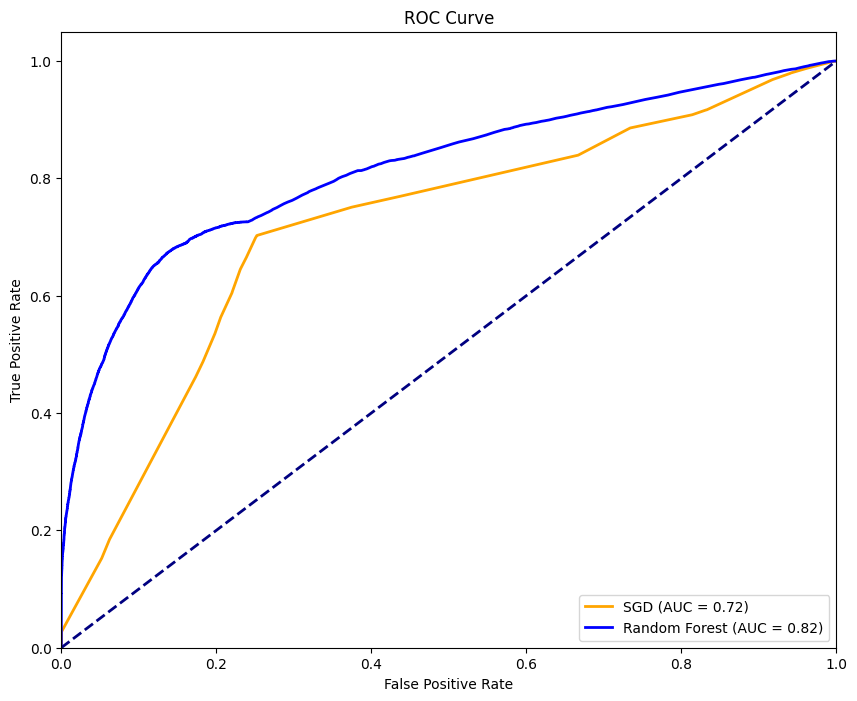

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate decision function and probabilities for models
sgd_scores = sgd_clf.decision_function(X_test)
forest_scores = forest_clf.predict_proba(X_test)[:, 1]

# Create false positive and true negative values for models
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, sgd_scores)
fpr_forest, tpr_forest, _ = roc_curve(y_test, forest_scores)

# Calculate scores for models
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)
roc_auc_forest = auc(fpr_forest, tpr_forest)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_sgd, tpr_sgd, color='orange', lw=2, label='SGD (AUC = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_forest, tpr_forest, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_forest)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.savefig('../results/roc-curve.png')
plt.show()

## 9. Model saving

Save the trained models using joblib. This allows for easy loading and reuse of the models for predictions or further analysis.

In [59]:
from joblib import dump

dump(sgd_clf, '../results/trained-sgdclassifier.joblib')
dump(forest_clf, '../results/trained-randomforest.joblib')

['../results/trained-randomforest.joblib']